In [142]:
import time
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2017) # set random seed value to get reproducible results
from copy import deepcopy

In [143]:
# store start time to get execution time of entire script
start_time = time.time()

### Load Data

In [144]:
grouping = 'stimulants'
#grouping = 'opioids'

df = pd.read_csv(grouping + '.csv', index_col=[0])
print(df.shape)
df.head()

(4603, 32)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,tsd_0_cd,und15_cd,CWSg_0_cd,srprobg_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,SFSg_0_cd,Raceg4_cd_gr_1,Raceg4_cd_gr_2,Raceg4_cd_gr_3,Raceg4_cd_gr_4
0,0,0,0,0,1,1,0,1,0,2,1,1,0,1,1,2,1,2,1,0,1,1,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,2,1,1,0,1,1,1,1,0,0,0
9,1,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0
11,0,0,0,0,0,0,1,1,0,2,0,1,0,1,1,1,2,2,1,0,2,1,1,0,0,0,0,0,1,0,0,0
16,0,0,0,0,0,0,0,1,0,2,1,1,0,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,1,0,0,0


### Outcome Distribution

In [145]:
df['init'].value_counts() # 1 represents a patient who did not initiate

0    4092
1     511
Name: init, dtype: int64

In [146]:
df['engage30'].value_counts() # 1 represents a patient who did not engage

0    2897
1    1706
Name: engage30, dtype: int64

### Modelling

In [147]:
def run_model(model, X_train, X_test, y_train, y_test, outcome):
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape) 
    
    # combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[outcome] == 0]
    positive = train_data[train_data[outcome] == 1]
    
    # upsample minority
    pos_upsampled = resample(positive, 
                               replace=True, # sample with replacement
                               n_samples=len(negative)) # match number in minority class
    
    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    X_train = upsampled.drop(columns=[outcome])
    y_train = upsampled[outcome]
    
    print("Sampled training set outcome counts:\n", y_train.value_counts().to_frame())
        
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5, scoring='roc_auc')
    top_model_ind = list(res['test_score']).index(max(list(res['test_score']))) # get index of top performing model
    top_model = res['estimator'][top_model_ind] # get top performing model
    
    y_pred = top_model.predict_proba(X_test)[:,1] 
    
    y_pred_bin = deepcopy(y_pred)
    y_pred_bin[y_pred_bin < 0.5] = 0
    y_pred_bin[y_pred_bin >= 0.5] = 1

    accuracy = metrics.accuracy_score(y_test, y_pred_bin)
    f1 = metrics.f1_score(y_test, y_pred_bin)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred_bin)
    recall = metrics.recall_score(y_test, y_pred_bin)
    
    print("Test set outcome counts:\n", y_test.value_counts().to_frame())
    print("Test set outcome percentages:\n", y_test.value_counts(normalize=True).to_frame())

    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC:", auc)
    
    result = permutation_importance(top_model, X_test, y_test, scoring='roc_auc')
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
    
    try:
        # random forest
        feature_importance = top_model.feature_importances_ 
        label = "RF-" + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(top_model.coef_[0]) # hazard ratios
        label = "LR-" + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
        
    features = X_train.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: result['importances_mean']})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df, [label, y_test.value_counts(normalize=True)[1], y_test.value_counts(normalize=True)[0], X_train.shape[0], accuracy, f1, precision, recall, auc]

In [148]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all(): # if non-binary
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    # print('Logistic Regression Features:', result.columns)
    return result

In [149]:
data = df.drop(columns=['init', 'engage30'])
engage30 = df['engage30']
init = df['init']

engage30_X_train, engage30_X_test, engage30_y_train, engage30_y_test = train_test_split(data, engage30, test_size=0.25, random_state=2017)
init_X_train, init_X_test, init_y_train, init_y_test = train_test_split(data, init, test_size=0.25)
performance = []

print('Features:', data.columns)

Features: Index(['female_cd', 'nonwhite_cd', 'unemplmt_cd', 'prsatx_cd', 'TRIg_0_cd',
       'TMIg_0_cd', 'SESg_0_cd', 'gvsg_cd', 'tsd_0_cd', 'und15_cd',
       'CWSg_0_cd', 'srprobg_cd', 'dldiag_cd', 'dssg_0_cd', 'epsg_0_cd',
       'adhdg_0_cd', 'cdsg_0_cd', 'suicprbs_0_cd', 'cjsig_0_cd', 'lrig_0_cd',
       'srig_0_cd', 'homeless_0_cd', 'S6_cd', 'gcsg_0_cd', 'ncar_cd',
       'SFSg_0_cd', 'Raceg4_cd_gr_1', 'Raceg4_cd_gr_2', 'Raceg4_cd_gr_3',
       'Raceg4_cd_gr_4'],
      dtype='object')


X_train: (3452, 30) X_test: (1151, 30) y_train: (3452,) y_test: (1151,)
Sampled training set outcome counts:
    engage30
1      2182
0      2182
Test set outcome counts:
    engage30
0       715
1       436
Test set outcome percentages:
    engage30
0  0.621199
1  0.378801
Accuracy: 0.6116420503909644
F1: 0.37482517482517486
Precision: 0.48028673835125446
Recall: 0.3073394495412844
AUC: 0.583274523641496


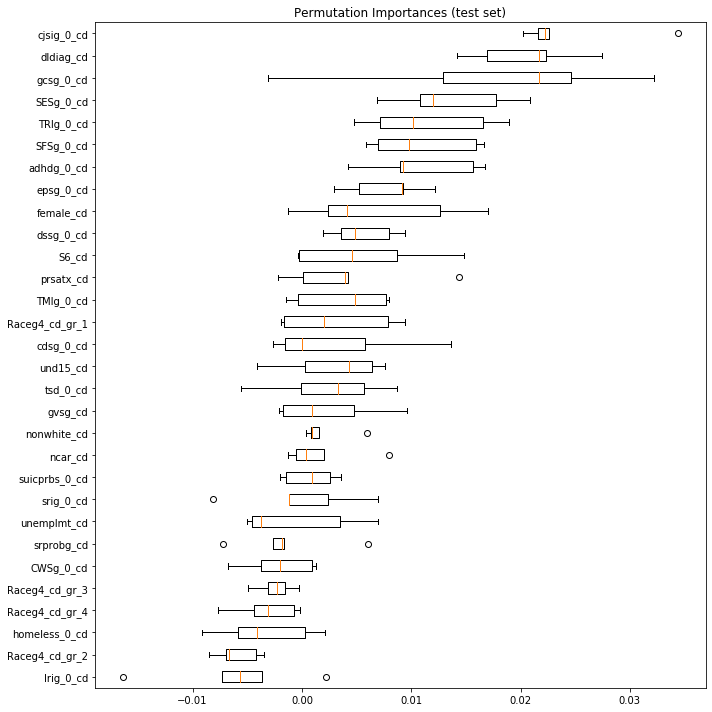

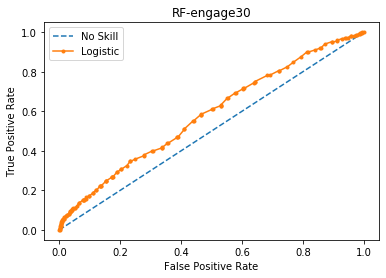

In [150]:
selected_features = ['female_cd',
 'nonwhite_cd',
 'unemplmt_cd',
 'prsatx_cd',
 'TRIg_0_cd',
 'TMIg_0_cd',
 'SESg_0_cd',
 'gvsg_cd',
 'srprobg_cd',
 'dssg_0_cd',
 'epsg_0_cd',
 'adhdg_0_cd',
 'cdsg_0_cd',
 'cjsig_0_cd',
 'lrig_0_cd',
 'srig_0_cd',
 'S6_cd',
 'gcsg_0_cd',
 'Raceg4_cd_gr_1',
 'Raceg4_cd_gr_3']
selected_features = list(engage30_X_train.columns)

feat_imp_rf_engage30, perf_stats_rf_engage30 = run_model(RandomForestClassifier(random_state=2017), engage30_X_train[selected_features], engage30_X_test[selected_features], engage30_y_train, engage30_y_test, 'engage30')

X_train: (3452, 45) X_test: (1151, 45) y_train: (3452,) y_test: (1151,)
Sampled training set outcome counts:
    engage30
1      2182
0      2182
Test set outcome counts:
    engage30
0       715
1       436
Test set outcome percentages:
    engage30
0  0.621199
1  0.378801
Accuracy: 0.5647263249348393
F1: 0.4892966360856269
Precision: 0.44036697247706424
Recall: 0.5504587155963303
AUC: 0.5738211329954449


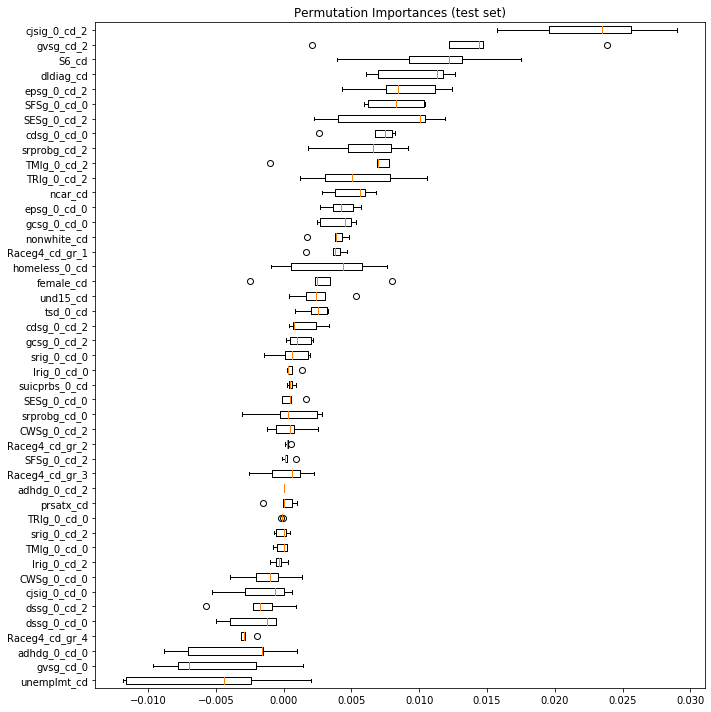

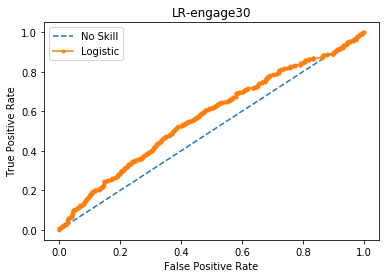

In [151]:
feat_imp_lr_engage30, perf_stats_lr_engage30 = run_model(LogisticRegression(C=0.75, max_iter=1000), get_logistic_regression_features(engage30_X_train), get_logistic_regression_features(engage30_X_test), engage30_y_train, engage30_y_test, 'engage30')

X_train: (3452, 30) X_test: (1151, 30) y_train: (3452,) y_test: (1151,)
Sampled training set outcome counts:
    init
1  3069
0  3069
Test set outcome counts:
    init
0  1023
1   128
Test set outcome percentages:
        init
0  0.888792
1  0.111208
Accuracy: 0.8748913987836664
F1: 0.08860759493670886
Precision: 0.23333333333333334
Recall: 0.0546875
AUC: 0.6405562683284458


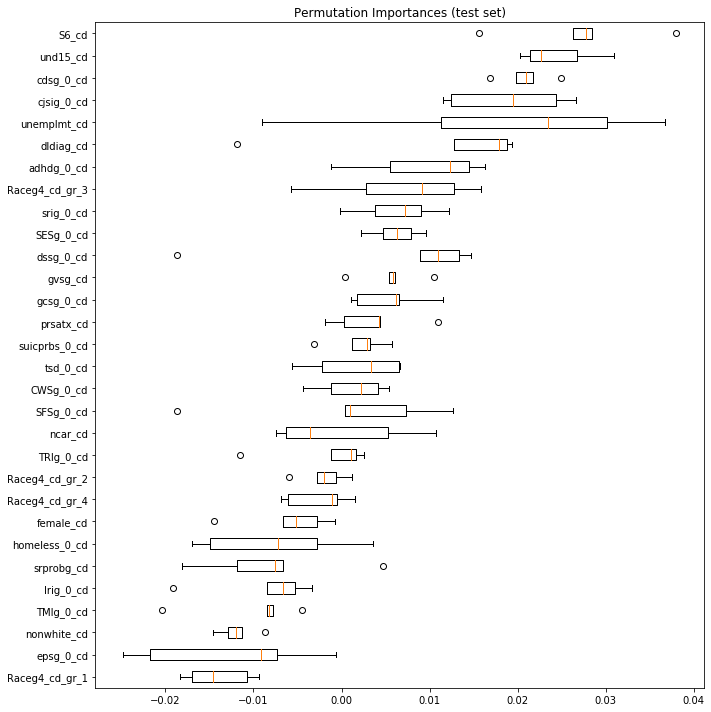

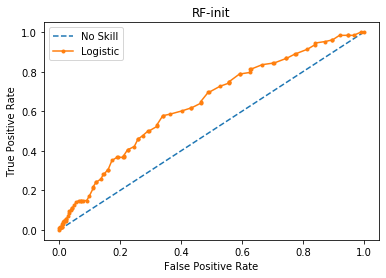

In [152]:
selected_features = ['female_cd',
 'unemplmt_cd',
 'TRIg_0_cd',
 'TMIg_0_cd',
 'SESg_0_cd',
 'gvsg_cd',
 'srprobg_cd',
 'dssg_0_cd',
 'epsg_0_cd',
 'adhdg_0_cd',
 'cjsig_0_cd',
 'S6_cd',
 'gcsg_0_cd',
 'SFSg_0_cd',
 'Raceg4_cd_gr_2',
 'Raceg4_cd_gr_4']
selected_features = list(init_X_train.columns)

feat_imp_rf_init, perf_stats_rf_init = run_model(RandomForestClassifier(random_state=2017), init_X_train[selected_features], init_X_test[selected_features], init_y_train, init_y_test, 'init')

X_train: (3452, 45) X_test: (1151, 45) y_train: (3452,) y_test: (1151,)
Sampled training set outcome counts:
    init
1  3069
0  3069
Test set outcome counts:
    init
0  1023
1   128
Test set outcome percentages:
        init
0  0.888792
1  0.111208
Accuracy: 0.5916594265855778
F1: 0.25396825396825395
Precision: 0.1593625498007968
Recall: 0.625
AUC: 0.6521642839687195


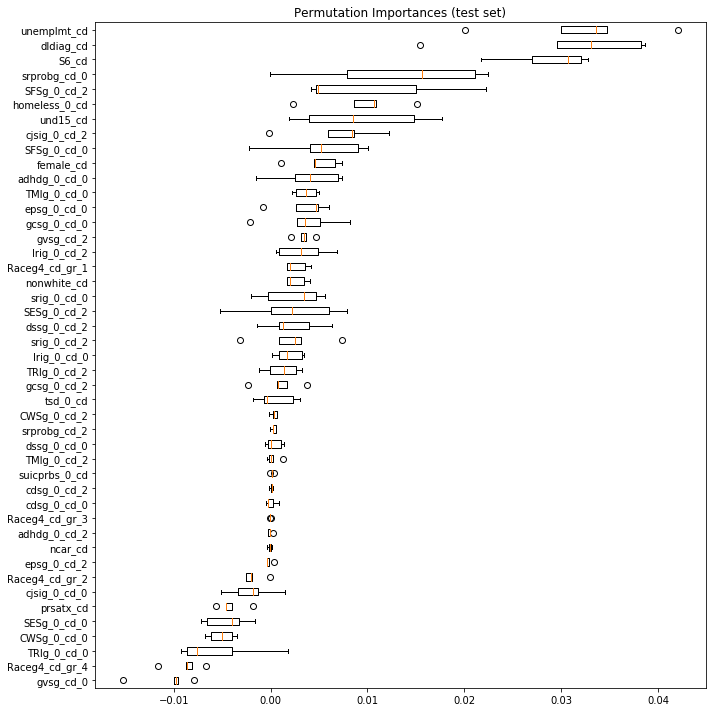

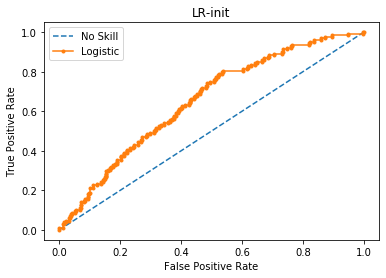

In [153]:
feat_imp_lr_init, perf_stats_lr_init = run_model(LogisticRegression(C=0.75, max_iter=1000), get_logistic_regression_features(init_X_train), get_logistic_regression_features(init_X_test), init_y_train, init_y_test, 'init')

### Feature Importance Analysis

In [154]:
feat_imp_rf_engage30 = feat_imp_rf_engage30.sort_values(by='RF-engage30', ascending=False)
feat_imp_rf_init = feat_imp_rf_init.sort_values(by='RF-init', ascending=False)

feat_imp_lr_engage30 = feat_imp_lr_engage30.sort_values(by='LR-engage30', ascending=False)
feat_imp_lr_init = feat_imp_lr_init.sort_values(by='LR-init', ascending=False)

In [155]:
feat_imp_rf_engage30.head(10) 

,RF-engage30
feature,
cjsig_0_cd,0.024216
dldiag_cd,0.020529
gcsg_0_cd,0.017689
SESg_0_cd,0.013656
TRIg_0_cd,0.011503
SFSg_0_cd,0.011041
adhdg_0_cd,0.010980
epsg_0_cd,0.007738
female_cd,0.006981


In [156]:
feat_imp_lr_engage30.head(10) 

,LR-engage30
feature,
cjsig_0_cd_2,0.022683
gvsg_cd_2,0.013450
S6_cd,0.011205
dldiag_cd,0.009747
epsg_0_cd_2,0.008757
SFSg_0_cd_0,0.008245
SESg_0_cd_2,0.007719
cdsg_0_cd_0,0.006606
srprobg_cd_2,0.006036


In [157]:
feat_imp_rf_init.head(10) 

,RF-init
feature,
S6_cd,0.027220
und15_cd,0.024388
cdsg_0_cd,0.020852
cjsig_0_cd,0.018894
unemplmt_cd,0.018495
dldiag_cd,0.011411
adhdg_0_cd,0.009485
Raceg4_cd_gr_3,0.006970
srig_0_cd,0.006414


In [158]:
feat_imp_lr_init.head(10) 

,LR-init
feature,
unemplmt_cd,0.032085
dldiag_cd,0.031000
S6_cd,0.028843
srprobg_cd_0,0.013418
SFSg_0_cd_2,0.010201
homeless_0_cd,0.009511
und15_cd,0.009380
cjsig_0_cd_2,0.007017
SFSg_0_cd_0,0.005213


In [159]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(grouping + '_feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feat_imp_rf_engage30.to_excel(writer, sheet_name='RF - engage30')
feat_imp_rf_init.to_excel(writer, sheet_name='RF - init')
feat_imp_lr_engage30.to_excel(writer, sheet_name='LR - engage30')
feat_imp_lr_init.to_excel(writer, sheet_name='LR - init')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Performance Statistics

In [160]:
# relates to performance when we do feature selection
rf_perf = pd.DataFrame(data=[perf_stats_rf_engage30, perf_stats_rf_init], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
rf_perf

,model-outcome,true%_1,true%_0,Training Size,Accuracy,F1,Precision,Recall,AUC
0,RF-engage30,0.378801,0.621199,4364,0.611642,0.374825,0.480287,0.307339,0.583275
1,RF-init,0.111208,0.888792,6138,0.874891,0.088608,0.233333,0.054688,0.640556


In [161]:
engage30_perf = pd.DataFrame(data=[perf_stats_rf_engage30, perf_stats_lr_engage30], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
engage30_perf

,model-outcome,true%_1,true%_0,Training Size,Accuracy,F1,Precision,Recall,AUC
0,RF-engage30,0.378801,0.621199,4364,0.611642,0.374825,0.480287,0.307339,0.583275
1,LR-engage30,0.378801,0.621199,4364,0.564726,0.489297,0.440367,0.550459,0.573821


In [162]:
init_perf = pd.DataFrame(data=[perf_stats_rf_init, perf_stats_lr_init], columns=['model-outcome', 'true%_1', 'true%_0', 'Training Size', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC'])
init_perf

,model-outcome,true%_1,true%_0,Training Size,Accuracy,F1,Precision,Recall,AUC
0,RF-init,0.111208,0.888792,6138,0.874891,0.088608,0.233333,0.054688,0.640556
1,LR-init,0.111208,0.888792,6138,0.591659,0.253968,0.159363,0.625000,0.652164


In [163]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 36 seconds ---
